# Transfer learning for pneumonia detection

## Reading and preprocessing data.

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/My Drive/Colab Notebooks/Xray_dataset.zip', 'r') as zip: 
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

Extracting all the files now...
Done!


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (450, 450)

train_path = '/content/chest_xray/chest_xray/train'
val_path = '/content/chest_xray/val'
test_path = '/content/chest_xray/test'

train_dataset = image_dataset_from_directory(train_path,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(val_path,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_path,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


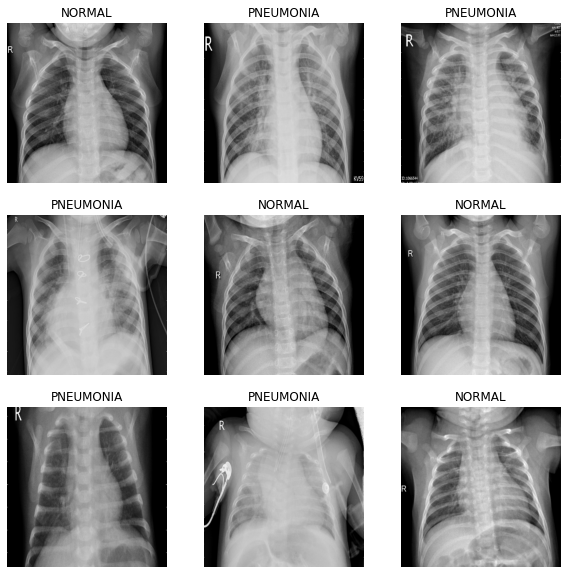

In [ ]:
import matplotlib.pyplot as plt

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print(f'Traning batches: {tf.data.experimental.cardinality(train_dataset)}')
print(f'Validation batches: {tf.data.experimental.cardinality(validation_dataset)}')
print(f'Test batches: {tf.data.experimental.cardinality(test_dataset)}')

Traning batches: 163
Validation batches: 1
Test batches: 20


In [ ]:
# Use buffered prefetching to load images from disk without having I/O become blocking. 

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Create the base model from the pre-trained model DenseNet121
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

In [ ]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 14, 14, 1024)


In [ ]:
# Freezing the convolutional base
base_model.trainable = False

base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 450, 450, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 456, 456, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 225, 225, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 225, 225, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
# Add a classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Adding dense layer to convert images into predictions.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1024)
(32, 1)


In [ ]:
'''
Chaining together the data augmentation, rescaling, base_model 
and feature extractor layers.
'''

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

'''
Compile the model before training it. 
binary cross-entropy loss with from_logits=True for 2 classes
'''


base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 450, 450, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 14, 14, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
# Use the validation set for a look on accuracy without training

initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print(f"initial loss: {loss0}")
print(f"initial accuracy: {accuracy0}")


1/1 [==============================] - 0s 3ms/step - loss: 0.7555 - accuracy: 0.5000
initial loss: 0.7554561495780945
initial accuracy: 0.5


In [ ]:
# Training the model

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
163/163 [==============================] - 63s 386ms/step - loss: 0.9116 - accuracy: 0.6258 - val_loss: 1.6713 - val_accuracy: 0.5625
Epoch 2/10
163/163 [==============================] - 62s 382ms/step - loss: 0.6658 - accuracy: 0.7084 - val_loss: 1.9582 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 62s 383ms/step - loss: 0.5524 - accuracy: 0.7548 - val_loss: 1.9117 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 63s 384ms/step - loss: 0.5177 - accuracy: 0.7657 - val_loss: 1.9446 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 63s 384ms/step - loss: 0.4553 - accuracy: 0.7985 - val_loss: 2.0275 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 63s 384ms/step - loss: 0.4076 - accuracy: 0.8225 - val_loss: 2.0304 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 63s 384ms/step - loss: 0.3725 - accuracy: 0.8368 - val_loss: 1.9109 - val_ac

In [ ]:

loss1, accuracy1 = model.evaluate(test_dataset)
print(f"initial loss: {loss1}")
print(f"initial accuracy: {accuracy1}")

20/20 [==============================] - 7s 356ms/step - loss: 0.6529 - accuracy: 0.7997
initial loss: 0.6528589129447937
initial accuracy: 0.7996794581413269


In [ ]:
# Unfreezing the base model
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  427


In [ ]:
# Recompile the model and use a 10th of the learning rate (to avoid overfitting)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 450, 450, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 14, 14, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,609,793
Non-trainable params: 428,736
_________________________________________________________________


In [ ]:
# If the model trained to convergence 
# this will improve the accuracy

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
163/163 [==============================] - 165s 1s/step - loss: 0.1738 - accuracy: 0.9262 - val_loss: 1.9791 - val_accuracy: 0.5625
Epoch 11/20
163/163 [==============================] - 164s 1s/step - loss: 0.0792 - accuracy: 0.9699 - val_loss: 0.2695 - val_accuracy: 0.9375
Epoch 12/20
163/163 [==============================] - 164s 1s/step - loss: 0.0542 - accuracy: 0.9783 - val_loss: 1.3610 - val_accuracy: 0.6250
Epoch 13/20
163/163 [==============================] - 163s 1s/step - loss: 0.0363 - accuracy: 0.9868 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 14/20
163/163 [==============================] - 163s 999ms/step - loss: 0.0275 - accuracy: 0.9900 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 15/20
163/163 [==============================] - 163s 1000ms/step - loss: 0.0215 - accuracy: 0.9923 - val_loss: 0.0292 - val_accuracy: 1.0000
Epoch 16/20
163/163 [==============================] - 163s 1s/step - loss: 0.0176 - accuracy: 0.9925 - val_loss: 7.4628e-04 - va

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

20/20 [==============================] - 7s 348ms/step - loss: 3.4317 - accuracy: 0.7308
Test accuracy : 0.7307692170143127


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1]
Labels:
 [1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1]


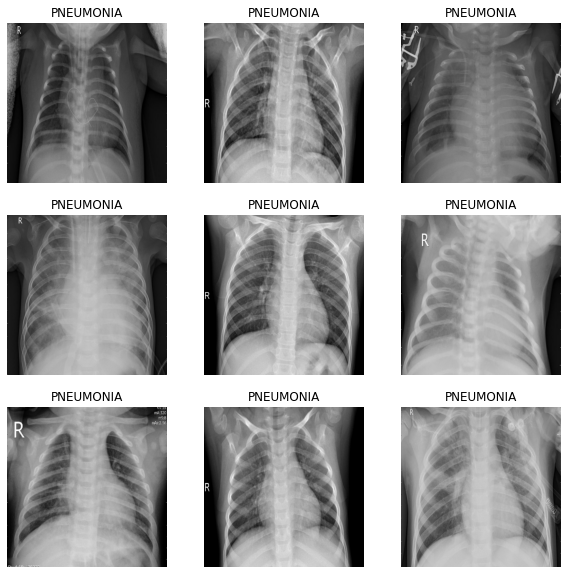

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
tf.keras.models.save_model(model, '/content/drive/My Drive/Colab Notebooks/ML_CV/Untitled Folder')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/ML_CV/Untitled Folder/assets
